In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import re
import coralme
import cobra
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

In [2]:
gem = cobra.io.load_json_model("./me_model_files/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


In [3]:
model = coralme.io.pickle.load_pickle_me_model("./me_model_files/MEModel-step3-pputida-TS-UPF36.pkl")

Read LP format model from file /tmp/tmphjzppvw6.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpsapy9r4y.lp
Reading time = 0.01 seconds
: 2162 rows, 5896 columns, 23426 nonzeros
Read LP format model from file /tmp/tmp3thhli3f.lp
Reading time = 0.01 seconds
: 2166 rows, 5894 columns, 23388 nonzeros


## Complement Annotation

In [4]:
# model = coralme.io.pickle.load_pickle_me_model("./me_model_files/KT2440-DLKcat.pkl")
model = coralme.io.pickle.load_pickle_me_model("./me_model_files/MEModel-step3-pputida-TS-UPF36.pkl")

Read LP format model from file /tmp/tmp4rw06r2k.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp2jfr2vvt.lp
Reading time = 0.01 seconds
: 2162 rows, 5896 columns, 23426 nonzeros
Read LP format model from file /tmp/tmp5tf3cjzp.lp
Reading time = 0.01 seconds
: 2166 rows, 5894 columns, 23388 nonzeros


In [5]:
Annotation = pandas.read_csv("./data-jul-2024/gene-metadata.csv",index_col=0)
Annotation = Annotation[~Annotation["old_locus_tag"].isna()].set_index("old_locus_tag")
Annotation.head()

,locus_tag,name,description,type,length
old_locus_tag,,,,,
PP_0001,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873
PP_0002,PP_RS00010,NaN,ParA family protein,CDS,792
PP_0003,PP_RS00015,rsmG,16S rRNA (guanine(527)-N(7))-methyltransferase RsmG,CDS,651
PP_0004,PP_RS00020,mnmG,tRNA uridine-5-carboxymethylaminomethyl(34) synthesis enzyme MnmG,CDS,1893
PP_0005,PP_RS00025,mnmE,tRNA uridine-5-carboxymethylaminomethyl(34) synthesis GTPase MnmE,CDS,1371


In [6]:
subsystems = pandas.Series({g.id.split("RNA_")[-1]:list(g.functions)[0] for g in model.metabolites if isinstance(g,coralme.core.component.TranscribedGene)},
                           name = "subsystem")

In [7]:
Annotation = pandas.concat([Annotation,subsystems],axis=1).drop("dummy")

In [8]:
def correct(x):
    if x == "Metabolic:Not Determined":
        return "tRNA Charging"
    if x == "tRNA-Charging":
        return "tRNA Charging"
    return x
Annotation["subsystem"] = Annotation["subsystem"].apply(lambda x:correct(x))

In [9]:
Annotation.to_csv("./GeneAnnotation.csv")

## Model properties

In [10]:
def get_breakdown(me,field):
    count = {}
    for instance in getattr(me,field):
        instance_type = instance.__class__.__name__
        if instance_type not in count.keys():
            count[instance_type] = 0
        count[instance_type] += 1
    return pandas.Series(count)

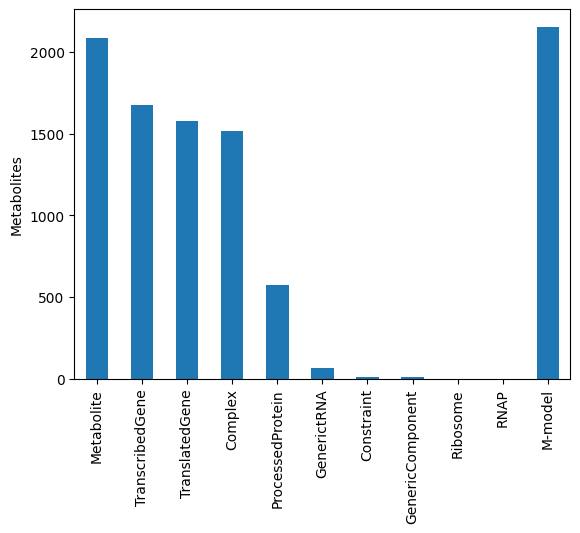

In [18]:
MetaboliteBreakdown = get_breakdown(model,"metabolites").sort_values(ascending=False)
MetaboliteBreakdown["M-model"] = len(gem.metabolites)
MetaboliteBreakdown.plot.bar()
plt.ylabel("Metabolites")
plt.savefig("./figures/metabolites-m-vs-me.svg",format="svg")

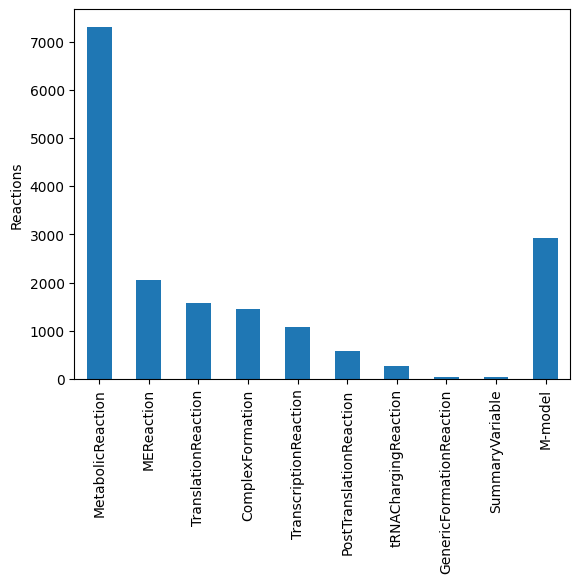

In [19]:
ReactionBreakdown = get_breakdown(model,"reactions").sort_values(ascending=False)
ReactionBreakdown["M-model"] = len(gem.reactions)
ReactionBreakdown.plot.bar()
plt.ylabel("Reactions")
plt.savefig("./figures/reactions-m-vs-me.svg",format="svg")

In [29]:
MetaboliteBreakdown,MetaboliteBreakdown.drop(["M-model","Metabolite"]).sum()

(Metabolite          2083
 TranscribedGene     1677
 TranslatedGene      1580
 Complex             1519
 ProcessedProtein     575
 GenerictRNA           65
 Constraint            13
 GenericComponent      12
 Ribosome               1
 RNAP                   1
 M-model             2153
 dtype: int64,
 5443)

In [30]:
ReactionBreakdown,ReactionBreakdown.drop(["M-model","MEReaction","MetabolicReaction"]).sum()

(MetabolicReaction           7310
 MEReaction                  2064
 TranslationReaction         1580
 ComplexFormation            1456
 TranscriptionReaction       1078
 PostTranslationReaction      576
 tRNAChargingReaction         271
 GenericFormationReaction      43
 SummaryVariable               36
 M-model                     2927
 dtype: int64,
 5040)

In [34]:
1676-len(gem.genes)

214

In [33]:
len(gem.genes)

1462

In [13]:
dct = {
    "me" : Annotation.loc[[g.id.split("RNA_")[-1] for g in model.all_genes]]["subsystem"].value_counts(),
    "m" : Annotation.loc[[g.id for g in gem.genes if g.id in Annotation.index]]["subsystem"].value_counts()
}
GeneBreakdown = pandas.DataFrame.from_dict(dct).fillna(0.)
GeneBreakdown

,me,m
Metabolic: No subsystem,16,11.0
Metabolic:Aliphatic open-chain ketones metabolism,1,1.0
Metabolic:Murein Recycling,4,4.0
Metabolic:S_Alanine_and_Aspartate_Metabolism,8,8.0
Metabolic:S_Alginate_biosynthesis,21,21.0
...,...,...
Metabolic:Unassigned,35,35.0
Post-translation,14,0.0
Transcription,19,0.0
Translation,188,3.0


In [14]:
GeneBreakdown[GeneBreakdown.index.str.contains("solvent")]

,me,m
Metabolic:S_Transport__solvent_extrusion,18,18.0


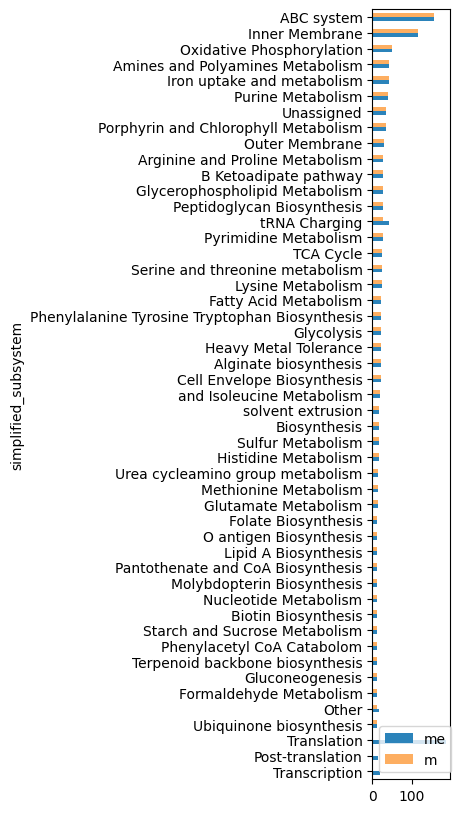

In [15]:
def simplify(s):
    s = s.split("__")[-1]
    s = s.replace("S_","")
    s = s.replace("_"," ")
    s = s.replace("Metabolic:","")
    
    if "Cofactor" in s:
        return "Cofactor metabolism"
    if "No subsystem" in s:
        return "Other"
    return s
GeneBreakdown = GeneBreakdown.reset_index()
GeneBreakdown["simplified_subsystem"] = GeneBreakdown["index"].apply(lambda x:simplify(x))
GeneBreakdown = GeneBreakdown.set_index("index")
# GeneBreakdown.groupby("simplified_subsystem").sum().sort_values("m",ascending=True).plot.barh(figsize=(1,20))
tmp = GeneBreakdown.groupby("simplified_subsystem").sum()
tmp[(tmp>10).any(axis=1)].sort_values("m",ascending=True).plot.barh(figsize=(1,10),color=["#2b83ba","#fdae61"])
plt.savefig("./figures/gene-functions-m-vs-me.svg",format="svg")

## Genome properties

In [10]:
from Bio import SeqIO
gb = [c for c in SeqIO.parse("./me_model_files/inputs/genome.gb","gb")]

In [136]:
dct = {}
for c in gb:
    for feature in c.features:
        if "locus_tag" not in feature.qualifiers:
            continue
        lt = feature.qualifiers["locus_tag"][0]
        ft = feature.type
        dct[lt] = ft
        # new_to_old[lt] = feature.qualifiers.get("old_locus_tag",[""])[0]
        # annotation[lt] = feature.qualifiers.get("product",[""])[0]
        # featuretype[lt] = feature.type
        # genelength[lt] = len(feature.extract(c).seq)

In [138]:
pandas.Series(dct).value_counts()

CDS      5564
tRNA       75
ncRNA      67
gene       57
rRNA       22
tmRNA       1
dtype: int64

In [140]:
pandas.Series(dct).value_counts().sum()

5786

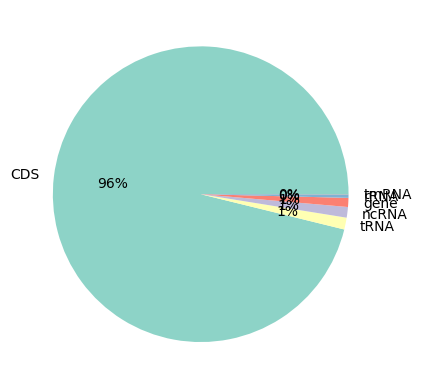

In [146]:
pandas.Series(dct).value_counts().plot.pie(autopct='%1.0f%%',colors=['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462'])
plt.savefig("./figures/cds-in-genome-pie.svg",format="svg")

In [155]:
pandas.Series({"m":len(gem.genes),"me":len(model.all_genes)})

m     1462
me    1676
dtype: int64

In [14]:
len(model.all_genes)

1676

In [15]:
len(gem.genes)

1462